# работа с данными

В чём проблема -- много признаков не заполнены (585 примеров из 2223)
Всего признаков 127, наиболее коррелирующих у Антонины было 44, но мы пока используем все.

есть 2 пути:
1. выкинуть примеры с признаками (выкинуть 585 примеров)
2. заполнить их средним.

сначала заполним средним


In [ ]:
import pandas as pd
df = pd.read_csv('RuFoLa фрагмент для практики.csv', encoding='utf-8')
# удаляем значения С2 -- их очень мало, они всё портят
# df = df.drop(df[df['level_number'] == 6].index)

In [ ]:
print(len(df[df['level_number'] == 6]))


27


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

texts = df['text'].values
labels1 = df['level_number'].values


# 1. Находим индекс столбца 'textometr_cefr'
split_column = 'textometr_cefr'
split_idx = df.columns.get_loc(split_column) + 1  # берём столбцы ПОСЛЕ него

# 2. Выбираем все числовые столбцы после 'textometr_cefr'
numeric_cols = df.iloc[:, split_idx:].select_dtypes(include=[np.number])

# 3. Преобразуем в матрицу numpy (каждая строка = строка DataFrame, столбцы = выбранные числовые признаки)
matrix = numeric_cols.to_numpy()

print("Размер матрицы:", matrix.shape)  # (n_rows, n_columns)
print(matrix[0])

print(df.isna().sum())
import numpy as np
import torch

# Если matrix - numpy array, конвертируем в torch tensor
if isinstance(matrix, np.ndarray):
    matrix = torch.from_numpy(matrix.astype(np.float32))

# Заменяем NaN на среднее по столбцу (только в столбцах с NaN)
for col in range(matrix.shape[1]):
    if torch.isnan(matrix[:, col]).any():  # Проверяем есть ли NaN в столбце
        col_mean = torch.nanmean(matrix[:, col])  # Среднее без учета NaN
        nan_mask = torch.isnan(matrix[:, col])
        matrix[nan_mask, col] = col_mean  # Заменяем только NaN

print("Остались ли NaN после обработки:", torch.isnan(matrix).any())

Размер матрицы: (2196, 127)
[ 3.400e+01  1.400e+01  3.800e+00  3.000e+00  1.000e+01  3.400e+00
  3.000e+00  0.000e+00 -1.600e+01  1.000e+02  1.000e+02  1.000e+02
  1.000e+02  1.000e+02  1.000e+02  3.230e-01  3.550e-01  3.550e-01
  3.550e-01  4.100e-01  2.400e+00  2.000e+01  0.000e+00  4.500e+01
  1.000e+02  7.300e+01  9.100e+01  1.000e+02  9.100e+01  1.000e+02
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  3.235e-01  1.100e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  5.880e-02
  2.000e-01  0.000e+00  0.000e+00  3.824e-01  1.300e+00  2.353e-01
  8.000e-01  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  3.529e-01  1.200e+00  2.940e-02  1.000e-01  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00 

In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels1)

# разделеляем данные на обучающую и тестовую выборки
# train_texts, vali_texts, train_labels, vali_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
# val_texts, test_texts, val_labels, test_labels = train_test_split(vali_texts, vali_labels, test_size=0.5, random_state=42)
# train_texts[:3]

In [ ]:
print(set(labels))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}


In [ ]:
!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which is incompatible.


# токенизатор + модель

In [ ]:
import torch
from transformers import AutoTokenizer


model_name = 'sberbank-ai/ruRoberta-large'
# model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Токенизируем тексты
# train_encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
encodings = tokenizer(list(texts), truncation=True, padding='max_length', max_length=512, return_tensors="pt")
# test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)
# val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

In [ ]:
print(encodings[:3])

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]


In [ ]:
import torch
from torch.utils.data import Dataset

class BertTextWithFeaturesDataset(Dataset):
    def __init__(self, encodings, features, labels):
        """
        encodings: результат tokenizer(texts, padding=True, truncation=True, return_tensors=None)
        features: numpy.ndarray формы (N, F) — лингвистические признаки
        labels: список или numpy.ndarray формы (N,)
        """
        self.encodings = encodings
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # соберем словарь с input_ids, attention_mask, features, labels
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = self.features[idx]
        item['labels'] = self.labels[idx]
        return item
ds = BertTextWithFeaturesDataset(encodings, matrix, labels)

<ipython-input-7-473497728>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)


In [ ]:
ds = BertTextWithFeaturesDataset(encodings, matrix, labels)
sample = ds[2000]

print("Ключи:", sample.keys())
print("input_ids shape:", sample['input_ids'].shape)
print("attention_mask shape:", sample['attention_mask'].shape)
print("features shape:", sample['features'].shape)
print("labels:", sample['labels'])

Ключи: dict_keys(['input_ids', 'attention_mask', 'features', 'labels'])
input_ids shape: torch.Size([512])
attention_mask shape: torch.Size([512])
features shape: torch.Size([127])
labels: tensor(2)


<ipython-input-8-91a905178bf6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
<ipython-input-8-91a905178bf6>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(ds, batch_size=4)

batch = next(iter(loader))
print("Batch keys:", batch.keys())
print("input_ids shape:", batch['input_ids'].shape)         # [4, 512]
print("attention_mask shape:", batch['attention_mask'].shape)
print("features shape:", batch['features'].shape)            # [4, 127]
print("labels shape:", batch['labels'].shape)                # [4]


Batch keys: dict_keys(['input_ids', 'attention_mask', 'features', 'labels'])
input_ids shape: torch.Size([4, 512])
attention_mask shape: torch.Size([4, 512])
features shape: torch.Size([4, 127])
labels shape: torch.Size([4])


<ipython-input-8-91a905178bf6>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
type(encodings)

transformers.tokenization_utils_base.BatchEncoding

Дообучаем BERT

In [ ]:
from transformers import AutoModel
import torch.nn as nn
import torch

class BertWithLingFeatures(nn.Module):
    def __init__(self, model_name, feature_dim, num_labels=1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.bert.config.hidden_size  # например, 768

        # Проекция лингвистических признаков под размер BERT
        self.feature_proj = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size),  # Выход = hidden_size
            nn.ReLU(),
            nn.Dropout(0.1))

        # Вход классификатора = hidden_size * 2
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 256),  # 768*2 = 1536
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels))

    def forward(self, input_ids, attention_mask, features, labels=None):
        # BERT-эмбеддинги
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS]-токен
        # print("Размер BERT-эмбеддингов:", pooled_output.shape)  # Должно быть (batch_size, hidden_size)

        # Проекция лингвистических признаков
        features_proj = self.feature_proj(features)
        # print("Размер лингвистических признаков:", features_proj.shape)  # Должен совпадать с hidden_size BERT

        # Объединённые признаки
        combined = torch.cat([pooled_output, features_proj], dim=1)
        # print("Размер объединённых признаков:", combined.shape)  # Должно быть (batch_size, hidden_size * 2)


        logits = self.classifier(combined)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [ ]:
print(len(labels))
print("Проверка меток:", np.unique(labels))  # Должны быть, например, [0, 1, 2, 3, 4, 5]
print("Есть ли NaN в features:", np.isnan(matrix).any())
print("Есть ли NaN в эмбэддингах BERT:", torch.isnan(encodings['input_ids'].float()).any())

2196
Проверка меток: [0 1 2 3 4]
Есть ли NaN в features: tensor(0, dtype=torch.uint8)
Есть ли NaN в эмбэддингах BERT: tensor(False)


<ipython-input-13-f047b7b17921>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("Есть ли NaN в features:", np.isnan(matrix).any())


In [ ]:
import torch
import numpy as np

# Проверяем, является ли matrix тензором PyTorch
if not isinstance(matrix, torch.Tensor):
    matrix = torch.tensor(matrix)  # Конвертируем в тензор, если это numpy-массив

# Находим индексы строк с NaN (работает для тензоров PyTorch)
nan_indices = torch.unique(torch.where(torch.isnan(matrix))[0]).tolist()
print(f"Найдено {len(nan_indices)} примеров с NaN в features")

# Удаляем проблемные примеры (если их немного)
if len(nan_indices) < 0.1 * len(matrix):  # Если меньше 10% данных
    clean_indices = [i for i in range(len(matrix)) if i not in nan_indices]
    matrix = matrix[clean_indices]
    labels = labels[clean_indices]
    texts = [texts[i] for i in clean_indices]  # Обновляем тексты
else:
    # Если NaN много — нужно чинить генерацию фичей
    raise ValueError("Слишком много NaN в features! Проверьте их расчёт")

Найдено 0 примеров с NaN в features


In [ ]:
from torch.utils.data import Subset
import random
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

indices = list(range(len(ds)))
random.shuffle(indices)

# Пропорции
train_size = int(0.7 * len(ds))
eval_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - eval_size


train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size + eval_size]
test_indices = indices[train_size + eval_size:]

train_dataset = BertTextWithFeaturesDataset(
    {k: v[train_indices] for k, v in encodings.items()},
    matrix[train_indices],
    labels[train_indices]
)

eval_dataset = BertTextWithFeaturesDataset(
    {k: v[eval_indices] for k, v in encodings.items()},
    matrix[eval_indices],
    labels[eval_indices]
)

test_dataset = BertTextWithFeaturesDataset(
    {k: v[test_indices] for k, v in encodings.items()},
    matrix[test_indices],
    labels[test_indices]
)


from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    pred_labels = np.argmax(logits, axis=-1)

    mask = labels != -100
    labels = labels[mask]
    pred_labels = pred_labels[mask]

    accuracy = accuracy_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(labels, pred_labels, average='weighted', zero_division=0)

    return {
        "Accuracy": 100 * accuracy,
        "Precision": 100 * precision,
        "Recall": 100 * recall,
        "F1": 100 * f1
    }

model = BertWithLingFeatures(
    model_name=model_name,
    feature_dim=127,
    num_labels=len(labels)
)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
training_args = TrainingArguments(output_dir="trainer_logs",
                                  evaluation_strategy="epoch", save_strategy='epoch', num_train_epochs=5,
                                  load_best_model_at_end=True, disable_tqdm=False,
                                  per_device_train_batch_size=4, warmup_ratio=0.1,
                                  gradient_accumulation_steps=4,
                                  metric_for_best_model="Accuracy")
trainer = Trainer(
    model=model,
    optimizers=(optimizer, None), # optimizers=(optimizer, scheduler)
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer), # добавляет паддинг в более короткие элементы батча
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics)
trainer.train(resume_from_checkpoint=False)

<ipython-input-7-473497728>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: limonovaaa24 (limonovaaa24-michigan-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,2.155400,34.954407,37.585939,34.954407,30.449717
1,No log,1.116944,51.063830,54.379527,51.063830,50.474570
2,No log,1.013409,57.142857,57.294593,57.142857,56.758448
4,No log,1.113710,54.103343,58.443330,54.103343,54.196866
4,No log,1.070100,56.231003,57.801346,56.231003,55.835498


<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it i

TrainOutput(global_step=480, training_loss=2.662775166829427, metrics={'train_runtime': 2797.2028, 'train_samples_per_second': 2.747, 'train_steps_per_second': 0.172, 'total_flos': 0.0, 'train_loss': 2.662775166829427, 'epoch': 4.99})

In [ ]:
from sklearn.metrics import classification_report
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

print("Classification Report:")
print(classification_report(labels, preds, digits=2))



<ipython-input-7-473497728>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.95      0.77        43
           1       0.42      0.44      0.43        50
           2       0.58      0.43      0.50        88
           3       0.60      0.55      0.57        83
           4       0.62      0.67      0.64        66

    accuracy                           0.58       330
   macro avg       0.57      0.61      0.58       330
weighted avg       0.58      0.58      0.57       330




Confusion Matrix:
[[41  1  1  0  0]
 [18 22 10  0  0]
 [ 4 26 38 15  5]
 [ 1  3 11 46 22]
 [ 0  1  5 16 44]]


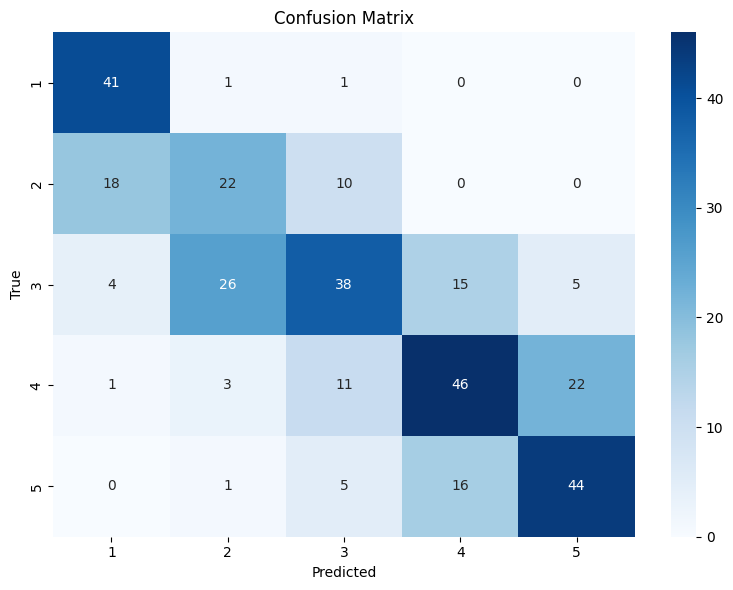

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(labels, preds, digits=2, output_dict=True)
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix:")
print(cm)

# Отрисовка confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()